In [1]:
import os, sys

import pymongo as pm
import numpy as np
import scipy.stats as stats
import pandas as pd
import json
import math

import matplotlib
from matplotlib import pylab, mlab, pyplot
import matplotlib.patches as mpatches
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')
from matplotlib import rcParams
from PIL import Image

from IPython.display import clear_output
import importlib

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
warnings.filterwarnings("ignore")


### Purpose of this notebook

The purpose of this notebook is to understand how much information each sketch produced in the `iterated_number` experiment contained information about the spatial layout of objects in the target array.

### set up file paths

In [2]:
# directory & file hierarchy
proj_dir = os.path.abspath('..')
analysis_dir = os.getcwd()
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))
stim_dir = os.path.abspath(os.path.join(proj_dir,'stimuli'))
sketch_dir = os.path.abspath(os.path.join(proj_dir,'sketches'))
datastructures_dir = os.path.join(analysis_dir,'datastructures')

## add helpers to python path
if os.path.join(proj_dir,'utils') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'utils'))   

def make_dir_if_not_exists(dir_name):   
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    return dir_name

## create directories that don't already exist        
result = [make_dir_if_not_exists(x) for x in [results_dir,plot_dir,csv_dir,datastructures_dir]]

## add utils to python path
import sys
if os.path.join(proj_dir,'utils') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'utils'))
import utils

### Load in example data

In [4]:
path_to_sketches = sketch_dir
sketch_paths = [os.path.join(path_to_sketches,i) for i in os.listdir(path_to_sketches)]

# path_to_stims = stim_dir
# stim_paths = [os.path.join(stim_dir, 'stims', i) for i in os.listdir(os.path.join(stim_dir, 'stims'))]
# stim_paths = [i for i in stim_paths if i.split('/')[-1] != '.DS_Store'] ## deborkify

In [5]:
# stim_paths

In [6]:
sketch_paths

['/Users/alles/repos/iterated_number/sketches/4019-010d3cc5-821a-4dae-981f-e81171af1699_owl_17_1_large_regular_17',
 '/Users/alles/repos/iterated_number/sketches/5257-896f3783-ecda-4daa-8ba0-1a976b05bcea_bear_2_2_small_regular_2',
 '/Users/alles/repos/iterated_number/sketches/5257-896f3783-ecda-4daa-8ba0-1a976b05bcea_bear_6_1_small_regular_6',
 '/Users/alles/repos/iterated_number/sketches/4019-010d3cc5-821a-4dae-981f-e81171af1699_owl_16_2_large_regular_16',
 '/Users/alles/repos/iterated_number/sketches/5257-896f3783-ecda-4daa-8ba0-1a976b05bcea_bear_5_3_small_regular_5']

In [7]:
## TODO: create a dictionary/dataframe that generates ...

['owl', '16', '2', 'large', 'regular', '16']


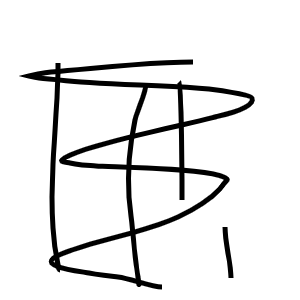

In [248]:
sampleNum = 3
## visualize sample image
this_sketch_path = sketch_paths[sampleNum]
cardinality = int(sketch_paths[sampleNum].split('/')[-1].split('_')[2])
im = Image.open(sketch_paths[sampleNum])
print(sketch_paths[sampleNum].split('/')[-1].split('_')[1:])
im

### very naive clustering method
* Convert image to numPy array
* Identify x,y coordinates of above-threshold pixels
* Apply k-means clustering (this is the "naive" part)
* Create reconstruction of cluster-segmented image
* Validate the segmentation results (via visual inspection for now)
* Extract centroid of each cluster in sketch
* Extract centroid of each cluster in stim
* Find 1-1 correspondence between centroids in sketch & stim
* Compute Euclidean distance between corresponding marks

In [249]:
## convert image to numPy array
im_flattened = np.array(im).mean(2)

In [250]:
## identify x,y coordinates of above-threshold pixels
pix_thresh = 10 #(this is a somewhat arbitrary choice of hyperparam)
coords = np.array(np.where(im_flattened>pix_thresh)).transpose()

In [251]:
## apply k-means clustering
from sklearn.cluster import KMeans
X = coords
num_clusters = cardinality
kmeans = KMeans(num_clusters, random_state=0).fit(X)
cluster_inds = kmeans.labels_ ## get cluster indices
assert len(cluster_inds)==len(coords) ## sanity check

In [252]:
## reconstruction of cluster-segmented image (initialize)
recon = np.zeros(im_flattened.shape) 

## create segmentation mask (where each pixel value is assigned the cluster index)
for ind, coord in enumerate(coords):
    recon[tuple(coord)]=cluster_inds[ind]+1 ## assign cluster index to that coord
    
assert len(np.unique(recon))==num_clusters+1 ## sanity check  

## construct rgb version of recon array
recon_rgb = np.dstack([recon]*3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


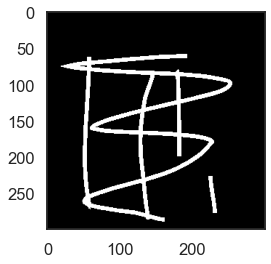

In [253]:
plt.imshow(recon_rgb*50)

In [254]:
## painting in coords with viridis colors
from matplotlib import cm
viridis = cm.get_cmap('viridis', num_clusters) ## color map
for this_cluster_ind in np.unique(cluster_inds):
    ## get matching coords
    row = np.where(recon_rgb==this_cluster_ind+1)[0] ## add one so that 1-indexed cluster inds match on recon_rgb
    col = np.where(recon_rgb==this_cluster_ind+1)[1]
    key_coords = list(set(zip(row, col)))
    
    ## paint in coords
    for coord in key_coords:
        recon_rgb[coord[0], coord[1], 0] = np.floor(viridis.colors[this_cluster_ind][0]*255) ## red channel
        recon_rgb[coord[0], coord[1], 1] = np.floor(viridis.colors[this_cluster_ind][1]*255) ## green channel
        recon_rgb[coord[0], coord[1], 2] = np.floor(viridis.colors[this_cluster_ind][2]*255) ## blue channel

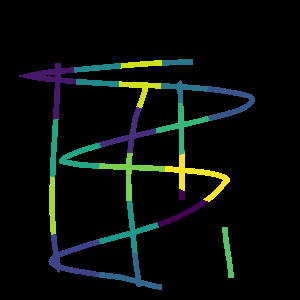

In [255]:
## visualize clusters
Image.fromarray(np.uint8(recon_rgb))

### next clustering method
* Convert image to numPy array
* Identify x,y coordinates of above-threshold pixels
* 
* Create reconstruction of cluster-segmented image
* Validate the segmentation results (via visual inspection for now)
* Extract centroid of each cluster in sketch
* Extract centroid of each cluster in stim
* Find 1-1 correspondence between centroids in sketch & stim
* Compute Euclidean distance between corresponding marks

In [256]:
## convert image to numPy array
im_flattened = np.array(im).mean(2)

## identify x,y coordinates of above-threshold pixels
pix_thresh = 10 #(this is a somewhat arbitrary choice of hyperparam)
coords = np.array(np.where(im_flattened>pix_thresh)).transpose()

In [257]:
# method 1 (not good)

continuousGroups = {}
currCoord = coords[0]
currGroup = []
groupInd = 0
continuous = True

for i,coord in enumerate(coords):
    
    diff = coord - currCoord
    continuous = np.sqrt(diff[0]**2 + diff[1]**2) < 80 # are we less than a pixel away?    
    currCoord = coord
        
    if continuous or (len(currGroup) == 0):
        currGroup.append(coord)
    else:
        continuousGroups[groupInd] = np.array(currGroup)
        currGroup = []
        groupInd += 1

In [258]:
continuousGroups.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,

In [259]:
np.shape(im_flattened)

(300, 300)

In [280]:
# method 2 (seems better, still need to have it refer to 'all coords but this one' rather than 'previous')


previousCoords = []
coordDict = {0:0} # key is index in previousCoords; value is candidate cluster
ClusterIDs = [0]
nearest,dist = 0,0

for i,coord in enumerate(coords):
#     if len(previousCoords) > 0:
#         nearest = np.argmin(np.sum(np.abs(coord - np.array(previousCoords)),axis=1)) # which pixel is closest?
#         dist = np.min(np.sum(np.abs(coord - np.array(previousCoords)),axis=1)) # how far is that pixel?
        
        
    coords_del = np.delete(coords, i, 0)
    nearest = np.argmin(np.sum(np.abs(coord - coords_del),axis=1)) # which pixel is closest?
    dist = np.min(np.sum(np.abs(coord - coords_del),axis=1)) # how far is that pixel?
    
     
#     previousCoords.append(coord) # add current coord to list of what we've gone through    
    
    if dist < 1.5:
        candidateCluster = coordDict[nearest] # what cluster are we considering adding it to? That of the nearest pixel
        coordDict[i] = candidateCluster
        
    else:
        candidateCluster = np.max(ClusterIDs) + 1 # what cluster are we considering
        coordDict[i] = np.max(ClusterIDs) + 1
        ClusterIDs.append(np.max(ClusterIDs) + 1)

KeyError: 15

In [276]:
clusterInds = list(coordDict.values())
len(np.unique(clusterInds))
np.min(np.sum(np.abs(coord - coords),axis=1))

15 in coordDict.keys()

False

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


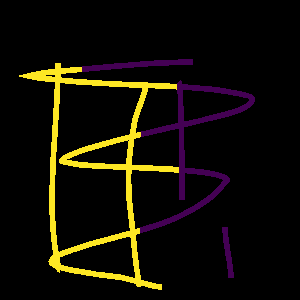

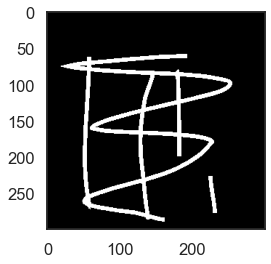

In [268]:
## reconstruction of cluster-segmented image (initialize)
recon = np.zeros(im_flattened.shape) 

## create segmentation mask (where each pixel value is assigned the cluster index)
for ind, coord in enumerate(coords):
    recon[tuple(coord)]=clusterInds[ind]+1 ## assign cluster index to that coord
    
assert len(np.unique(recon))==len(np.unique(clusterInds))+1 ## sanity check  

## construct rgb version of recon array
recon_rgb = np.dstack([recon]*3)

plt.imshow(recon_rgb*50)

## painting in coords with viridis colors
from matplotlib import cm
viridis = cm.get_cmap('viridis', len(np.unique(clusterInds))) ## color map
for this_cluster_ind in np.unique(clusterInds):
    ## get matching coords
    row = np.where(recon_rgb==this_cluster_ind+1)[0] ## add one so that 1-indexed cluster inds match on recon_rgb
    col = np.where(recon_rgb==this_cluster_ind+1)[1]
    key_coords = list(set(zip(row, col)))
    
    ## paint in coords
    for coord in key_coords:
        recon_rgb[coord[0], coord[1], 0] = np.floor(viridis.colors[this_cluster_ind][0]*255) ## red channel
        recon_rgb[coord[0], coord[1], 1] = np.floor(viridis.colors[this_cluster_ind][1]*255) ## green channel
        recon_rgb[coord[0], coord[1], 2] = np.floor(viridis.colors[this_cluster_ind][2]*255) ## blue channel

## visualize clusters
Image.fromarray(np.uint8(recon_rgb))